In [1]:
import os
from pathlib import Path
import logging
import itertools

import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import xgboost as xgb

from capstone.config import CapstoneConfig
from capstone.data_access import DataClass
from capstone.features import Features
from capstone.features.helpers import spacy_init, spacy_normalize, tfidf_init
from capstone.utils.constants import (
    TEXT,
    TARGET
)

sns.set_style("darkgrid")
PARENT_PATH = Path(os.getcwd()).parent.absolute()
FORMAT = "%(asctime)s - %(name)s - %(levelname)s - %(message)s"
logging.basicConfig(format=FORMAT, level=logging.INFO)

In [2]:
config = CapstoneConfig()
config.CURRENT_PATH = PARENT_PATH

data = DataClass(config)
df = data.build()
df.head(3)

,Text,Standard mapping?
0,General Quality System Requirements […] Genera...,[regulatory standards management]
1,General Quality System Requirements […] Manage...,"[quality planning, quality management]"
2,General Quality System Requirements […] Manage...,[quality management]


In [3]:
features = Features(config)
dev, test = features.build(df)

2022-10-22 18:59:42,413 - capstone.features.features - INFO - Cleaning text
2022-10-22 18:59:42,488 - capstone.features.features - INFO - Applying language model
2022-10-22 19:00:23,198 - capstone.features.features - INFO - Applying lemmatization and removing stopwords
2022-10-22 19:00:23,556 - capstone.utils.utils - INFO - func:clean took: 41.14 sec
2022-10-22 19:00:24,210 - capstone.utils.utils - INFO - func:fit took: 41.80 sec
2022-10-22 19:00:24,214 - capstone.features.features - INFO - Cleaning text
2022-10-22 19:00:24,276 - capstone.features.features - INFO - Applying language model
2022-10-22 19:00:55,547 - capstone.features.features - INFO - Applying lemmatization and removing stopwords
2022-10-22 19:00:55,843 - capstone.utils.utils - INFO - func:clean took: 31.63 sec
2022-10-22 19:00:56,124 - capstone.utils.utils - INFO - func:transform took: 31.91 sec
2022-10-22 19:00:56,125 - capstone.utils.utils - INFO - func:fit_transform took: 1 min and 13.71 sec
2022-10-22 19:00:56,127 -

In [5]:
len(list(features.vectorizer.get_feature_names_out()))

562

<AxesSubplot:>

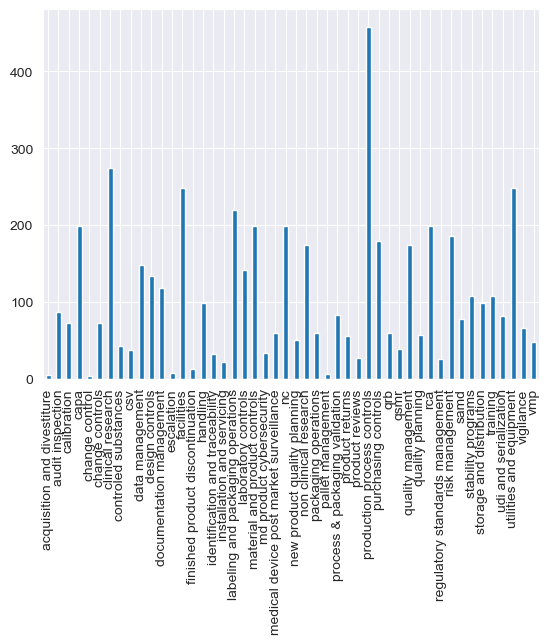

In [6]:
dev[features.mlb.classes_.tolist()].sum(axis=0).plot.bar()

<AxesSubplot:>

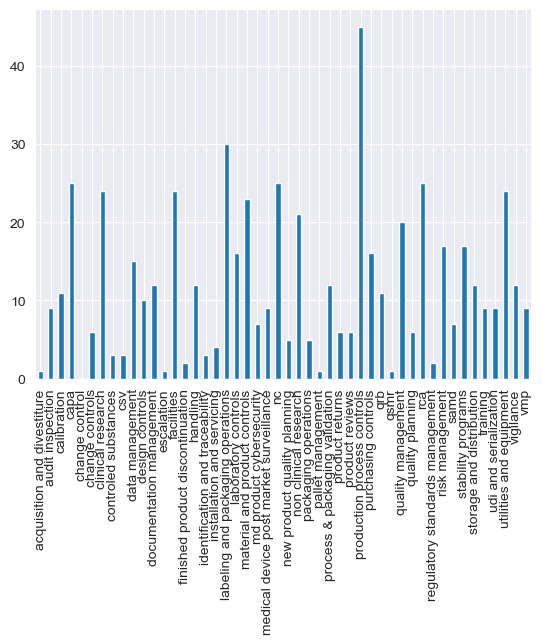

In [7]:
test[features.mlb.classes_.tolist()].sum(axis=0).plot.bar()

In [8]:
X_dev = dev[features.vectorizer.get_feature_names_out()].to_numpy()
Y_dev = dev[features.mlb.classes_.tolist()].to_numpy().astype(int)

X_test = test[features.vectorizer.get_feature_names_out()].to_numpy()
Y_test = test[features.mlb.classes_.tolist()].to_numpy().astype(int)

In [66]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import hamming_loss, make_scorer


In [67]:
rf_classifier = MultiOutputClassifier(RandomForestClassifier())

In [68]:
def ham_loss(y_true, y_pred):
    return hamming_loss(y_true, y_pred)

score = make_scorer(ham_loss, greater_is_better=False)

In [69]:
params = {
    'estimator__n_estimators': [i for i in range(50, 225, 25)],
    'estimator__max_depth': [10, 20, 30, 40, 50],
    'estimator__max_features': ["sqrt", "log2"],
    "estimator__class_weight": ["balanced_subsample"]
}



In [64]:
ratios = dev.shape[0] / dev[features.mlb.classes_].sum(axis=0)
ratios = round(ratios).astype(int)
weights = [{0: 1, 1: ratios[i]} for i in range(len(features.mlb.classes_))]


In [70]:
clf = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=params,
    scoring=score,
    cv=5,
    return_train_score=False,
    verbose=10
)

In [71]:
clf.fit(X_dev, Y_dev)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START estimator__class_weight=balanced_subsample, estimator__max_depth=30, estimator__max_features=sqrt, estimator__n_estimators=200
[CV 1/5; 1/10] END estimator__class_weight=balanced_subsample, estimator__max_depth=30, estimator__max_features=sqrt, estimator__n_estimators=200;, score=-0.021 total time= 1.4min
[CV 2/5; 1/10] START estimator__class_weight=balanced_subsample, estimator__max_depth=30, estimator__max_features=sqrt, estimator__n_estimators=200
[CV 2/5; 1/10] END estimator__class_weight=balanced_subsample, estimator__max_depth=30, estimator__max_features=sqrt, estimator__n_estimators=200;, score=-0.021 total time= 1.7min
[CV 3/5; 1/10] START estimator__class_weight=balanced_subsample, estimator__max_depth=30, estimator__max_features=sqrt, estimator__n_estimators=200


In [22]:
rf_classifier.estimator[-1]

RandomForestClassifier(random_state=42)

In [9]:
model = LinearSVC(class_weight="balanced", C=0.5, max_iter=2000)
models = MultiOutputClassifier(model)
models.fit(X_dev, Y_dev)

MultiOutputClassifier(estimator=LinearSVC(C=0.5, class_weight='balanced',
                                          max_iter=2000))

0.06479113384484228

In [14]:
# import xgboost as xgb

from sklearn.datasets import make_multilabel_classification
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

# create sample dataset
X, y = make_multilabel_classification(n_samples=3000, n_features=45, n_classes=20, n_labels=1,
                                      allow_unlabeled=False, random_state=42)

In [12]:
hamming_loss(Y_dev, models.predict(X_dev))

0.04656827880512091

In [ ]:
hamming_loss(Y_test, models.predict(X_test))

In [10]:
models.score(X_dev, Y_dev)

0.24751066856330015

In [28]:
models.score(X_test, Y_test)

0.1483375959079284

In [30]:
p = models.predict(X_test)

In [31]:
Y_test[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [32]:
p[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0])

In [46]:
np.any(,)

array([[ True]])

In [49]:
np.equal(p, Y_test)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ..., False,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True]])

<AxesSubplot:>

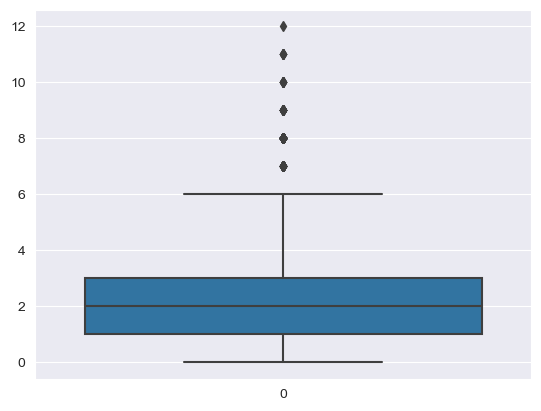

In [62]:
sns.boxplot((models.predict(X_dev) != Y_dev).sum(axis=1))

<AxesSubplot:>

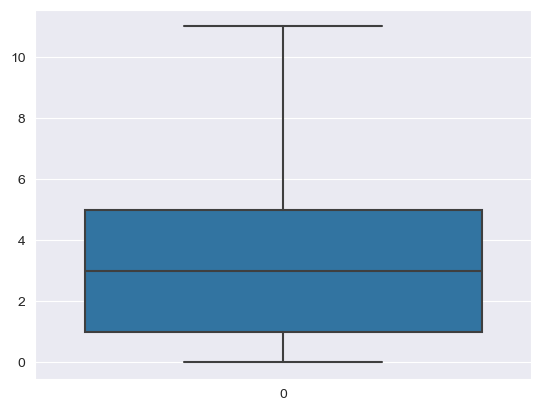

In [63]:
sns.boxplot((models.predict(X_test) != Y_test).sum(axis=1))

In [18]:
forest = RandomForestClassifier(random_state=1)
multi_target_forest = MultiOutputClassifier(forest)
multi_target_forest.fit(X_dev, Y_dev)

MultiOutputClassifier(estimator=RandomForestClassifier(random_state=1))

In [19]:
hamming_loss(Y_dev, multi_target_forest.predict(X_dev))

0.004012565196775723

In [20]:
hamming_loss(Y_test, multi_target_forest.predict(X_test))

0.023071184995737425

<AxesSubplot:>

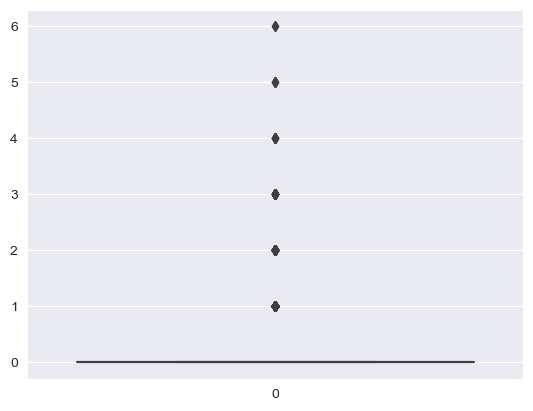

In [67]:
sns.boxplot((multi_target_forest.predict(X_dev) != Y_dev).sum(axis=1))

<AxesSubplot:>

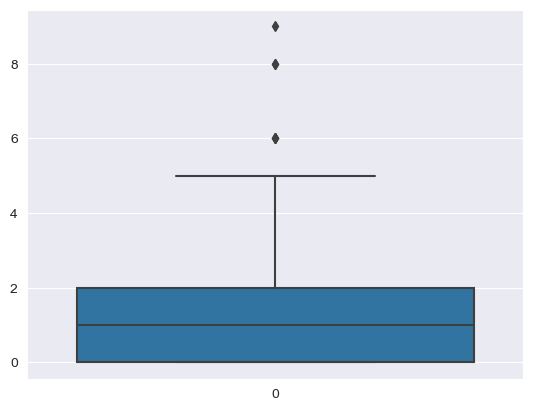

In [68]:
sns.boxplot((multi_target_forest.predict(X_test) != Y_test).sum(axis=1))